In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/food-demand-forecasting/meal_info.csv
/kaggle/input/food-demand-forecasting/sample_submission.csv
/kaggle/input/food-demand-forecasting/fulfilment_center_info.csv
/kaggle/input/food-demand-forecasting/train.csv
/kaggle/input/food-demand-forecasting/test.csv


In [54]:
meal_info = pd.read_csv('/kaggle/input/food-demand-forecasting/meal_info.csv')
center_info = pd.read_csv('/kaggle/input/food-demand-forecasting/fulfilment_center_info.csv')

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('/kaggle/input/food-demand-forecasting/train.csv')
df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [4]:
df['week'].describe()

count    456548.000000
mean         74.768771
std          41.524956
min           1.000000
25%          39.000000
50%          76.000000
75%         111.000000
max         145.000000
Name: week, dtype: float64

In [4]:
df.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
dtype: int64

In [5]:
df.shape

(456548, 9)

In [6]:
import numpy as np
import pandas as pd

def create_features(df):
    # Cyclical features
    df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
    df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)
    
    # Lag features
    df['demand_lag_1'] = df.groupby(['center_id', 'meal_id'])['num_orders'].shift(1)
    df['demand_lag_2'] = df.groupby(['center_id', 'meal_id'])['num_orders'].shift(2)

    # Rolling features
    df['rolling_mean_3'] = df.groupby(['center_id', 'meal_id'])['num_orders'].transform(lambda x: x.shift(1).rolling(3).mean())
    df['rolling_std_3'] = df.groupby(['center_id', 'meal_id'])['num_orders'].transform(lambda x: x.shift(1).rolling(3).std())

    # Price-related features
    df['price_diff'] = df['base_price'] - df['checkout_price']
    df['price_ratio'] = df['checkout_price'] / (df['base_price'] + 1)

    # Demand averages
    df['meal_avg_demand'] = df.groupby('meal_id')['num_orders'].transform('mean')
    df['center_meal_avg'] = df.groupby(['center_id', 'meal_id'])['num_orders'].transform('mean')

    # Time-based features
    df['quarter'] = df['week'] // 13
    df['weeks_since_event'] = df['week'] - 100
    df['normalized_week'] = df['week'] - df.groupby('meal_id')['week'].transform('min')

    # Promo-based features
    df['is_promo'] = df['emailer_for_promotion'] + df['homepage_featured']
    df['promo_effect'] = df['is_promo'] * df['price_diff']

    # Center-level and meal popularity
    df['price_per_center'] = df.groupby('center_id')['checkout_price'].transform('mean')
    df['meal_popularity_in_center'] = df.groupby(['center_id', 'meal_id'])['num_orders'].transform('mean')
    
    return df


In [7]:
df = create_features(df)

In [8]:
cols_to_fill = ['demand_lag_1', 'demand_lag_2', 'rolling_mean_3', 'rolling_std_3']

for col in cols_to_fill:
    df[col] = df[col].fillna(df[col].mean())

In [9]:
df.isnull().sum()

id                           0
week                         0
center_id                    0
meal_id                      0
checkout_price               0
base_price                   0
emailer_for_promotion        0
homepage_featured            0
num_orders                   0
week_sin                     0
week_cos                     0
demand_lag_1                 0
demand_lag_2                 0
rolling_mean_3               0
rolling_std_3                0
price_diff                   0
price_ratio                  0
meal_avg_demand              0
center_meal_avg              0
quarter                      0
weeks_since_event            0
normalized_week              0
is_promo                     0
promo_effect                 0
price_per_center             0
meal_popularity_in_center    0
dtype: int64

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [11]:
X = df.drop(['id', 'num_orders'], axis=1)
y =  df['num_orders']

In [12]:
X_train, X_test, y_train, y_test = train_test_split (X,y, test_size=0.2, random_state=44)

In [13]:
meal_le = LabelEncoder()
center_le = LabelEncoder()

In [14]:
X_train['meal_id_ecd'] = meal_le.fit_transform(X_train['meal_id'])
X_test['meal_id_ecd'] = meal_le.transform(X_test['meal_id'])

X_train['center_id_encd'] = center_le.fit_transform(X_train['center_id'])
X_test['center_id_encd'] = center_le.transform(X_test['center_id'])

In [15]:
X_train.head()

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,week_sin,week_cos,demand_lag_1,...,center_meal_avg,quarter,weeks_since_event,normalized_week,is_promo,promo_effect,price_per_center,meal_popularity_in_center,meal_id_ecd,center_id_encd
65809,23,43,2631,150.35,251.23,1,0,0.354605,-0.935016,134.0,...,273.650350,1,-77,22,1,100.88,332.954344,273.650350,42,18
68603,24,58,1993,116.43,116.43,0,0,0.239316,-0.970942,204.0,...,211.717241,1,-76,23,0,0.00,327.178533,211.717241,26,25
387627,124,61,1230,324.98,325.98,0,0,0.663123,-0.748511,365.0,...,114.604167,9,24,123,0,0.00,339.411771,114.604167,5,27
390171,125,59,1543,387.03,470.51,0,0,0.568065,-0.822984,82.0,...,76.362319,9,25,124,0,0.00,332.126715,76.362319,12,26
100215,35,74,1993,96.06,95.06,0,0,-0.885456,-0.464723,285.0,...,231.779310,2,-65,34,0,-0.00,334.103313,231.779310,26,35


In [16]:
X_train = X_train.drop(['center_id','meal_id'], axis=1)
X_test = X_test.drop(['center_id','meal_id'], axis=1)

In [17]:
X_train.head()

,week,checkout_price,base_price,emailer_for_promotion,homepage_featured,week_sin,week_cos,demand_lag_1,demand_lag_2,rolling_mean_3,...,center_meal_avg,quarter,weeks_since_event,normalized_week,is_promo,promo_effect,price_per_center,meal_popularity_in_center,meal_id_ecd,center_id_encd
65809,23,150.35,251.23,1,0,0.354605,-0.935016,134.0,123.0,90.333333,...,273.650350,1,-77,22,1,100.88,332.954344,273.650350,42,18
68603,24,116.43,116.43,0,0,0.239316,-0.970942,204.0,188.0,185.000000,...,211.717241,1,-76,23,0,0.00,327.178533,211.717241,26,25
387627,124,324.98,325.98,0,0,0.663123,-0.748511,365.0,68.0,167.000000,...,114.604167,9,24,123,0,0.00,339.411771,114.604167,5,27
390171,125,387.03,470.51,0,0,0.568065,-0.822984,82.0,123.0,109.333333,...,76.362319,9,25,124,0,0.00,332.126715,76.362319,12,26
100215,35,96.06,95.06,0,0,-0.885456,-0.464723,285.0,338.0,293.333333,...,231.779310,2,-65,34,0,-0.00,334.103313,231.779310,26,35


In [18]:
from sklearn.preprocessing import StandardScaler

In [19]:
ss = StandardScaler()

In [20]:
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform (X_test)

## Model Training

In [26]:
from sklearn.ensemble import RandomForestRegressor

In [27]:
rf = RandomForestRegressor()

In [36]:
rf.fit(X_train_ss,y_train)

RandomForestRegressor()

In [38]:
y_pred = rf.predict(X_test_ss)

In [39]:
from sklearn.metrics import r2_score

rs = r2_score(y_test, y_pred)
rs

0.87384397163262

In [40]:
fi = rf.feature_importances_
f_name = X_train.columns

In [41]:
f_imp = pd.DataFrame({
    'feater_imp' : fi,
    'Feature' : f_name
}).sort_values(by='feater_imp', ascending=False)

<BarContainer object of 25 artists>

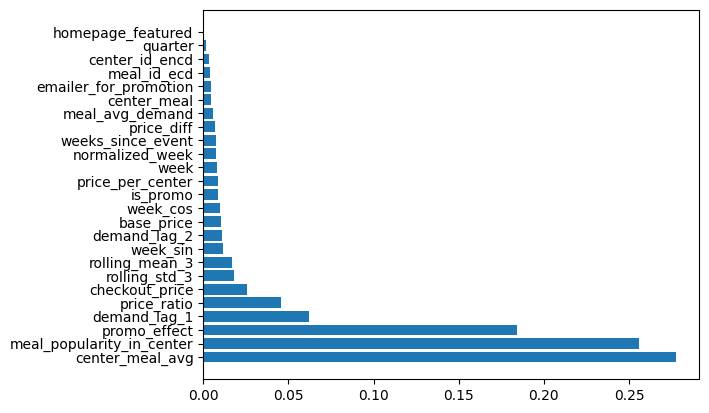

In [42]:
plt.barh(f_imp['Feature'], f_imp['feater_imp'])

## XG

In [21]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1)
model.fit(X_train_ss,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [22]:
from sklearn.metrics import r2_score

In [23]:
y_pred = model.predict(X_test_ss)
r2 = r2_score(y_test, y_pred)
r2

0.8697615331288691

# Test data

In [24]:
test = pd.read_csv('/kaggle/input/food-demand-forecasting/test.csv')

In [25]:
test.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0
2,1212707,146,55,2539,157.14,159.14,0,0
3,1082698,146,55,2631,162.02,162.02,0,0
4,1400926,146,55,1248,163.93,163.93,0,0


In [26]:
test.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
dtype: int64

In [27]:
test.shape

(32573, 8)

In [28]:
test['num_orders'] = np.nan

In [29]:
combined = pd.concat([df, test], ignore_index=True)

In [30]:
combined.shape

(489121, 26)

In [31]:
combined.sort_values(by=['center_id', 'meal_id', 'week'], inplace=True)

In [32]:
combined

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,week_sin,...,price_ratio,meal_avg_demand,center_meal_avg,quarter,weeks_since_event,normalized_week,is_promo,promo_effect,price_per_center,meal_popularity_in_center
2370,1436842,1,10,1062,181.39,181.39,0,0,865.0,0.120537,...,0.994517,423.165574,949.944828,0.0,-99.0,0.0,0.0,0.0,335.615692,949.944828
5273,1205013,2,10,1062,183.36,182.36,0,0,782.0,0.239316,...,1.000000,423.165574,949.944828,0.0,-98.0,1.0,0.0,-0.0,335.615692,949.944828
8175,1447751,3,10,1062,184.36,182.36,0,0,851.0,0.354605,...,1.005454,423.165574,949.944828,0.0,-97.0,2.0,0.0,-0.0,335.615692,949.944828
11064,1014968,4,10,1062,182.36,183.36,0,0,1202.0,0.464723,...,0.989152,423.165574,949.944828,0.0,-96.0,3.0,0.0,0.0,335.615692,949.944828
13918,1003563,5,10,1062,183.39,181.39,0,0,958.0,0.568065,...,1.005483,423.165574,949.944828,0.0,-95.0,4.0,0.0,-0.0,335.615692,949.944828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345410,1255251,112,186,2956,583.03,581.03,0,0,82.0,0.822984,...,1.001718,92.518831,32.400000,8.0,12.0,53.0,0.0,-0.0,334.082335,32.400000
348601,1436164,113,186,2956,583.03,582.03,0,0,40.0,0.885456,...,1.000000,92.518831,32.400000,8.0,13.0,54.0,0.0,-0.0,334.082335,32.400000
351905,1000576,114,186,2956,583.03,581.03,0,0,27.0,0.935016,...,1.001718,92.518831,32.400000,8.0,14.0,55.0,0.0,-0.0,334.082335,32.400000
355206,1429037,115,186,2956,581.03,583.03,0,0,15.0,0.970942,...,0.994863,92.518831,32.400000,8.0,15.0,56.0,0.0,0.0,334.082335,32.400000


In [33]:
combined = create_features(combined)

In [34]:
train_feat = combined[~combined['num_orders'].isna()].copy()
test_feat = combined[combined['num_orders'].isna()].copy()

In [35]:
test_feat

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,week_sin,...,price_ratio,meal_avg_demand,center_meal_avg,quarter,weeks_since_event,normalized_week,is_promo,promo_effect,price_per_center,meal_popularity_in_center
459185,1177098,146,10,1062,190.18,190.18,0,0,NaN,-0.935016,...,0.994769,423.165574,949.944828,11,46,145,0,0.00,336.654578,949.944828
462444,1486011,147,10,1062,193.03,194.03,0,0,NaN,-0.885456,...,0.989745,423.165574,949.944828,11,47,146,0,0.00,336.654578,949.944828
465769,1301735,148,10,1062,191.09,191.09,0,0,NaN,-0.822984,...,0.994794,423.165574,949.944828,11,48,147,0,0.00,336.654578,949.944828
469079,1273097,149,10,1062,189.15,189.15,0,0,NaN,-0.748511,...,0.994741,423.165574,949.944828,11,49,148,0,0.00,336.654578,949.944828
472366,1450902,150,10,1062,194.06,193.06,0,0,NaN,-0.663123,...,1.000000,423.165574,949.944828,11,50,149,0,-0.00,336.654578,949.944828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463493,1185326,148,186,2867,506.37,728.53,1,1,NaN,-0.822984,...,0.694104,88.226026,37.717172,11,48,147,2,444.32,334.492482,37.717172
466827,1049627,149,186,2867,554.87,728.53,1,0,NaN,-0.748511,...,0.760586,88.226026,37.717172,11,49,148,1,173.66,334.492482,37.717172
470135,1006124,150,186,2867,727.53,727.53,0,0,NaN,-0.663123,...,0.998627,88.226026,37.717172,11,50,149,0,0.00,334.492482,37.717172
479876,1298818,153,186,2867,727.53,726.53,0,0,NaN,-0.354605,...,1.000000,88.226026,37.717172,11,53,152,0,-0.00,334.492482,37.717172


In [36]:
test_feat.drop(columns=['num_orders', 'id'], inplace=True)

In [37]:
test_feat

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,week_sin,week_cos,demand_lag_1,...,price_ratio,meal_avg_demand,center_meal_avg,quarter,weeks_since_event,normalized_week,is_promo,promo_effect,price_per_center,meal_popularity_in_center
459185,146,10,1062,190.18,190.18,0,0,-0.935016,0.354605,958.0,...,0.994769,423.165574,949.944828,11,46,145,0,0.00,336.654578,949.944828
462444,147,10,1062,193.03,194.03,0,0,-0.885456,0.464723,NaN,...,0.989745,423.165574,949.944828,11,47,146,0,0.00,336.654578,949.944828
465769,148,10,1062,191.09,191.09,0,0,-0.822984,0.568065,NaN,...,0.994794,423.165574,949.944828,11,48,147,0,0.00,336.654578,949.944828
469079,149,10,1062,189.15,189.15,0,0,-0.748511,0.663123,NaN,...,0.994741,423.165574,949.944828,11,49,148,0,0.00,336.654578,949.944828
472366,150,10,1062,194.06,193.06,0,0,-0.663123,0.748511,NaN,...,1.000000,423.165574,949.944828,11,50,149,0,-0.00,336.654578,949.944828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463493,148,186,2867,506.37,728.53,1,1,-0.822984,0.568065,NaN,...,0.694104,88.226026,37.717172,11,48,147,2,444.32,334.492482,37.717172
466827,149,186,2867,554.87,728.53,1,0,-0.748511,0.663123,NaN,...,0.760586,88.226026,37.717172,11,49,148,1,173.66,334.492482,37.717172
470135,150,186,2867,727.53,727.53,0,0,-0.663123,0.748511,NaN,...,0.998627,88.226026,37.717172,11,50,149,0,0.00,334.492482,37.717172
479876,153,186,2867,727.53,726.53,0,0,-0.354605,0.935016,NaN,...,1.000000,88.226026,37.717172,11,53,152,0,-0.00,334.492482,37.717172


In [38]:
X_train_ss.shape

(365238, 24)

In [39]:
test_feat['meal_id_ecd'] = meal_le.transform(test_feat['meal_id'])

test_feat['center_id_encd'] = center_le.transform(test_feat['center_id'])

In [40]:
test_feat = test_feat.drop(['meal_id', 'center_id'], axis=1)

In [41]:
test_feat.shape

(32573, 24)

In [42]:
ss_test = StandardScaler()

test_feat_ss = ss.fit_transform (test_feat)

In [43]:
prediction = model.predict(test_feat_ss)

In [44]:
prediction

array([1120.3328 , 1954.498  , 1944.5144 , ...,  466.68546,  559.6024 ,
        600.4099 ], dtype=float32)

In [45]:
prediction = np.round(prediction).astype(int)

In [46]:
prediction

array([1120, 1954, 1945, ...,  467,  560,  600])

In [49]:
pred = pd.DataFrame({"Prediction": prediction})

In [50]:
pred

,Prediction
0,1120
1,1954
2,1945
3,1936
4,1948
...,...
32568,902
32569,812
32570,467
32571,560


In [51]:
pred.to_csv("food_demand_prdctn.csv", index=False)

In [52]:
test['num_orders'] = pred

In [53]:
test.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1028232,146,55,1885,158.11,159.11,0,0,1120
1,1127204,146,55,1993,160.11,159.11,0,0,1954
2,1212707,146,55,2539,157.14,159.14,0,0,1945
3,1082698,146,55,2631,162.02,162.02,0,0,1936
4,1400926,146,55,1248,163.93,163.93,0,0,1948


# Ploting Graph

<Axes: xlabel='week', ylabel='num_orders'>

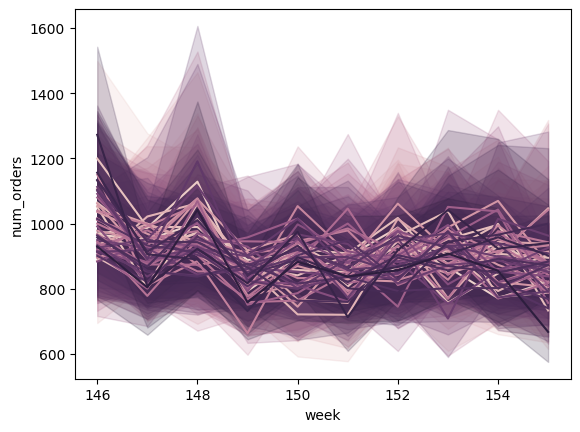

In [59]:
import seaborn as sns
sns.lineplot(data=test, x='week', y='num_orders', hue='meal_id', legend=False)

<Axes: xlabel='week', ylabel='num_orders'>

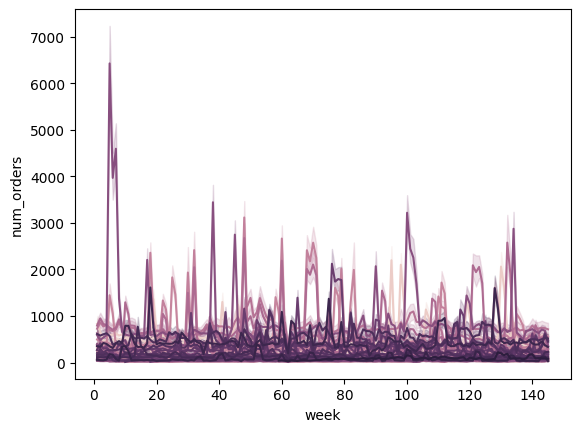

In [60]:
sns.lineplot(data=df, x='week', y='num_orders', hue='meal_id', legend=False)